### replace default value of argument (e.g. `gamma`, `hi_min`) to defined values in module file

In [24]:
import numpy as np
import matplotlib.pyplot as plt

In [74]:
from matplotlib import rcParams
rcParams['font.size'] = 15

In [194]:
from math import sqrt
from numbers import Real

def get_stepsize_quad(ti, xi, Fx, dxFx, dx2Fx, hi_max,
                     gamma = 0.8, hi_min = 0.0001, forward=True):
    
    if not forward: raise NotImplementedError(
        "backward time flow hasn't been dealt yet")
    assert isinstance(gamma, Real) and (0 < gamma) and (gamma < 1)
    
    _hi_guess = None
    
    ## initial guess of stepsize
    _F_tixi, _dxFx_tixi, _dx2Fx_tixi = Fx(ti,xi), dxFx(ti,xi), dx2Fx(ti,xi)
    _a1_0 = _dxFx_tixi*_dxFx_tixi - 2.0 * _dx2Fx_tixi * _F_tixi
    _a2_0 = _dxFx_tixi
    _D_D = _a2_0 * _a2_0 - _a1_0
    
#     print("_a1_0:{} / _a2_0:{}".format(_a1_0,_a2_0))
    
    if _a1_0 > 0:
        if _a2_0 <= 0: _hi_guess = hi_max
        else:
            if _D_D >= 0: _hi_guess = gamma * _a2_0 / _a1_0
            else: _hi_guess = hi_max
    elif _a1_0 < 0: _hi_guess = gamma * (_a2_0 + sqrt(_D_D)) / (2.0 * _a1_0)
    elif _a1_0 == 0:
        if _a2_0 > 0: _hi_guess = gamma / (2.0 * _a2_0)
        else: _hi_guess = hi_max
#         print("_hi_guess:{}".format(_hi_guess))
    else: raise Exception("Unexpected")
    
    assert isinstance(_hi_guess, Real)
    _D_hi_0 = _a1_0 * _hi_guess*_hi_guess - 2.0 * _a2_0 * _hi_guess + 1
    assert _D_hi_0 > 0

    
    ## fine-tune
    _a1, _a2 = _a1_0, _a2_0
    while _hi_guess > hi_min:
        _D_hi = _a1 * _hi_guess*_hi_guess - 2.0 * _a2 * _hi_guess + 1
        if _D_hi > 0: break
        print("reduced")
        _ti = ti + _hi_guess
        _F, _dxFx, _dx2Fx = Fx(_ti,xi), dxFx(_ti,xi), dx2Fx(_ti,xi)
        _a1 = _dxFx*_dxFx - 2.0 * _dx2Fx * _F
        _a2 = _dxFx
        _hi_guess *= gamma
    
    if (_hi_guess <= hi_min):
        raise Exception("hi_min reached - couldn't find good stepsize")         
    _hi = min(_hi_guess, hi_max)
    
    return _hi

In [271]:
import numpy as np
from scipy.optimize import root

def back_euler_quad(t0, x0, t_max, Fx, dxFx, dx2Fx, hi_max, 
                    t_arr=None, **stepsize_kwarg):
    
    if t_arr is None: t_arr = np.array((t0, t_max))
    else: assert isinstance(t_arr, np.ndarray) and (t_arr.ndim == 1)
    
    assert t0 == t_arr[0]
#     _t_list = [t0]
#     _x_list = [x0]
    _x_arr = np.empty_like(t_arr, dtype=float)
    _x_arr[0] = x0
    
    _t, _x = t0, x0
    
    for _i in range(1,t_arr.size):
#     for _t_target in t_arr[1:]:
        _t_target = t_arr[_i]
        while _t < _t_target:
#             print("_t, _x = ({}, {})".format(_t,_x))
#             _ti, _xi = _t_list[-1], _x_list[-1]
            _h = get_stepsize_quad(_t, _x, Fx, dxFx, dx2Fx, hi_max, 
                                   **stepsize_kwarg)
            _t_next = _t + _h
            if _t_next > _t_target:
                _h = _t_target - _t
                _t_next = _t_target
                
            def _Gx(x): return (x - _x) - _h * Fx(_t_next, x)
            _sol = root(_Gx, _x)  # jacobian may be supplied
            if _sol.success and _sol.x.size == 1: _x_next, = _sol.x
            else: raise Exception(
                "unique root search failed due to '{}'".format(_sol.message))                
            _t, _x = _t_next, _x_next
            
        _x_arr[_i] = _x_next
#             _t_list.append(_t_next), _x_list.append(_x_next)

#     _t_arr, _x_arr = np.array(_t_list), np.array(_x_list)
    return t_arr, _x_arr


### Test for several set of initial values

## How can I find those kind of `t0+1/x0` singular point .. where propagation is not possible .. although,, in Bohm, there is always solution if started from regular point -- thus, small enough stepsize always exist to

In [268]:
t_arr

array([-0.5       , -0.45677778, -0.41355556, -0.37033333, -0.32711111,
       -0.28388889, -0.24066667, -0.19744444, -0.15422222, -0.111     ])

In [272]:
c0, c1, c2 = 0, 0, 1
def Fx(t, x): return c0 + c1 * x + c2 * x*x
def dxFx(t, x): return c1 + 2.0*c2*x
def dx2Fx(t, x): return 2.0 * c2

t0, x0 = -0.5, 2.0
t_max = -0.111

assert t_max < (t0 + 1/x0)

h_max, gamma, h_min = 0.01, 0.5, 0.0001

def x_analytic(t): return - 1.0 / (t - t0 - 1.0/x0)

t_arr = np.linspace(t0, t_max, 10)
t_arr, x_arr = back_euler_quad(t0, x0, t_max, Fx, dxFx, dx2Fx, 
                               h_max, t_arr=t_arr, gamma=gamma, hi_min=h_min)
f_arr = x_analytic(t_arr)

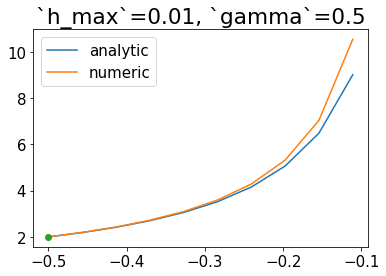

In [273]:
fig, ax = plt.subplots()

l_ana, = ax.plot(t_arr, f_arr)
l_num, = ax.plot(t_arr, x_arr)

ax.plot(t0, x0, 'o')

ax.set_title("`h_max`={}, `gamma`={}".format(h_max, gamma))
ax.legend((l_ana, l_num), ("analytic", "numeric"))

# ax.set_ylim(-1000,0)

In [180]:
# fig.savefig("step-esti-quad-hmax-{}-gamma-{}-test-0.png".format(h_max,gamma))

In [10]:
get_stepsize_quad(t0, x0, Fx, dxFx, dx2Fx, hi_max=1.0)

0.18181818181818182

In [98]:
c0, c1 = 0.2, 1.0
def Fx(t, x): return c0 + c1*x
def dxFx(t, x): return c1
def dx2Fx(t, x): return 0.0

t0, x0 = -0.5, -1.1

In [99]:
get_stepsize_quad(t0, x0, Fx, dxFx, dx2Fx, hi_max=1.0)

0.8